# Home Credit Default Risk

[Home Credit Default Risk](https://www.kaggle.com/competitions/home-credit-default-risk/) Kaggle competition.


## 1. Introduction

This is a binary Classification task: we want to predict whether the person applying for a home credit will be able to repay their debt or not. Our model will have to predict a 1 indicating the client will have payment difficulties: he/she will have late payment of more than X days on at least one of the first Y installments of the loan in our sample, 0 in all other cases.

The dataset is composed of multiple files with different information about loans taken. In this project, we will work exclusively with the primary files: `application_train_aai.csv` and `application_test_aai.csv`.

We will use [Area Under the ROC Curve](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc?hl=es_419) as the evaluation metric, so our models will have to return the probabilities that a loan is not paid for each row.

In [1]:
# Import libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.validation import check_is_fitted

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from src import config, data_utils, preprocessing

### Getting the data

To access the data for this project, you only need to execute the code below. This will download three files inside the `dataset` folder:

- `application_train_aai.csv`: Training dataset you must use to train and find the best hyperparameters on your model.

- `application_test_aai.csv`: Test dataset without labels. Because of the absence of labels, you can't use this dataset for your experiments. You will use the file only at the end after you choose what you think is the best model for the tasks. You will have to use that model to fill values in the `TARGET` column using the model predictions. Then submit this dataset alongside this Jupyter notebook, AnyoneAI will internally evaluate your model's accuracy in the hidden data and communicate later ;).

- `HomeCredit_columns_description.csv`: This file contains descriptions for the columns in train and test datasets.


1.1. Load the training and test datasets. Also, the auxiliary file `HomeCredit_columns_description.csv` has additional information about the features in the dataset.

In [2]:
app_train, app_test, columns_description = data_utils.get_datasets()

### Exploratory Data Analysis


#### Dataset Basics

1.2. Print how many samples do we have in our train and test datasets.

In [3]:
### TODO Complete in this cell: shape of the dataset
print(f'shape train Dataframe {app_train.shape}, shape test Dataframe {app_test.shape}')

shape train Dataframe (246008, 122), shape test Dataframe (61503, 122)


1.3. List all columns in the train dataset.

In [4]:
### TODO Complete in this cell: Show all columns in the training dataset
app_train.columns

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=122)

1.4. Show the first 5 records of the training dataset, transpose the dataframe to see each record as a column and features as rows, make sure all features are visualized. Take your time to review what kind of information you can gather from this data.

For reference only, it should look like this:

|0|1|2|3|4
|---|---|---|---|---
Unnamed: 0|187399|84777|268140|270686|33785
SK_ID_CURR|317244|198357|410700|413785|139141
TARGET|0|0|0|0|0
NAME_CONTRACT_TYPE|Cash loans|Cash loans|Cash loans|Cash loans|Cash loans
...|...|...|...|...|...
AMT_REQ_CREDIT_BUREAU_DAY|0.0|0.0|0.0|0.0|0.0

In [5]:
### TODO Complete in this cell: show first 5 records in a transposed table
pd.set_option('display.max_rows', None)
app_train.head().T

,0,1,2,3,4
SK_ID_CURR,428247,140966,407283,434300,446788
TARGET,0,0,0,0,0
NAME_CONTRACT_TYPE,Cash loans,Cash loans,Revolving loans,Cash loans,Cash loans
CODE_GENDER,F,M,F,F,F
FLAG_OWN_CAR,N,Y,N,N,N
FLAG_OWN_REALTY,N,Y,Y,N,N
CNT_CHILDREN,0,1,0,0,0
AMT_INCOME_TOTAL,157500.0,90000.0,405000.0,90000.0,67500.0
AMT_CREDIT,634500.0,1223010.0,540000.0,439740.0,323388.0
AMT_ANNUITY,30523.5,51948.0,27000.0,18630.0,18054.0


1.5. Show the distribution of the target variable values: print the total value count and the percentage of each value, plot this relationship.

total values: 246008, percentage of 0: 91.97139930408767 , percentage of 1: 8.028600695912328


Text(0.5, 1.0, 'relation TARGET')

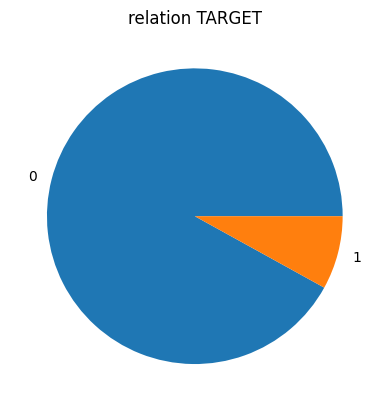

In [6]:

total_values = app_train.shape[0]
value0 = app_train['TARGET'].value_counts()[0]
value1 = app_train['TARGET'].value_counts()[1]

print(f'total values: {total_values}, percentage of 0: {(value0/total_values)*100} , percentage of 1: {(value1/total_values)*100}')

plt.figure()
plt.pie(app_train['TARGET'].value_counts(), labels = ['0', '1'])
plt.title('relation TARGET')


1.6. Show the number of columns of each data type.

Just for giving you an idea, the output should look like this (not exactly the same numbers):

```python
float64    45
int64      32
object     10
```

In [7]:
### TODO Complete in this cell: show number of columns per data type
types = {}
for type in app_train.dtypes:
    if type not in types:
        types[type] = 1
    else:
        types[type] += 1
pd.Series(types)

int64      41
object     16
float64    65
dtype: int64

1.7. For categorical variables (`object` data type), show the number of distinct values in each column (number of labels).

Just for giving you an idea, the output should look like this (not exactly the same numbers):

```python
NAME_CONTRACT_TYPE             5
CODE_GENDER                    2
FLAG_OWN_CAR                   1
FLAG_OWN_REALTY                1
...
```

In [8]:
### TODO Complete in this cell: show number of unique values per categorical column
categorical = {}
for column in app_train.columns:
    if app_train[column].dtype == 'object':
        categorical[column] = app_train[column].nunique()

pd.Series(categorical)       

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

1.8. Analyzing missing data: show the percentage of missing data for each column ordered by percentage descending (show only the 20 columns with higher missing pct)

Just for giving you an idea, the output should look like this (not exactly the same numbers and columns names):

```python
                   Total   Percent
COMMONAREA_AVG    121000      85.2
COMMONAREA_MODE   121000      76.6
COMMONAREA_MEDI   121000      62.9
...
```

In [9]:
### TODO Complete in this cell: checking missing data
df_missing = pd.DataFrame(columns=['column', 'percent', 'total'])
total_rows = app_train.shape[0]

for i, column in enumerate(app_train.columns):
    nnull = app_train[column].isnull().sum()
    percent = nnull/total_rows
    df_missing.loc[i,'percent'] = percent
    df_missing.loc[i,'column'] = column
    df_missing.loc[i,'total'] = total_rows

df_missing.sort_values(by = 'percent', ascending= False).head(20)

,column,percent,total
76,COMMONAREA_MEDI,0.699933,246008
48,COMMONAREA_AVG,0.699933,246008
62,COMMONAREA_MODE,0.699933,246008
70,NONLIVINGAPARTMENTS_MODE,0.69549,246008
56,NONLIVINGAPARTMENTS_AVG,0.69549,246008
84,NONLIVINGAPARTMENTS_MEDI,0.69549,246008
86,FONDKAPREMONT_MODE,0.685185,246008
68,LIVINGAPARTMENTS_MODE,0.684913,246008
54,LIVINGAPARTMENTS_AVG,0.684913,246008
82,LIVINGAPARTMENTS_MEDI,0.684913,246008


#### Analyzing distribution of variables

1.9. Show the distribution of credit amounts.

*Hint:* Take a look at `AMT_CREDIT` column.

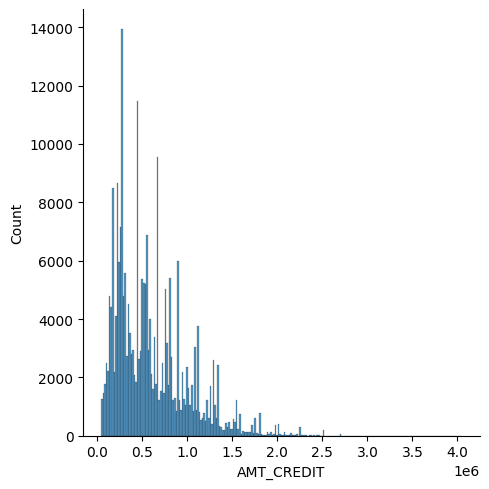

In [10]:
### TODO Complete in this cell: distribution of credit amounts
plt.Figure()
sns.displot(app_train['AMT_CREDIT'])

1.10. Plot the education level of the credit applicants, show the percentages of each category. Also print the total counts for each category.

*Hint:* Take a look at `NAME_EDUCATION_TYPE` column.

                             edu   count   percent
0  Secondary / secondary special  174657  0.709965
1               Higher education   59990  0.243854
2              Incomplete higher    8248  0.033527
3                Lower secondary    2984   0.01213
4                Academic degree     129  0.000524


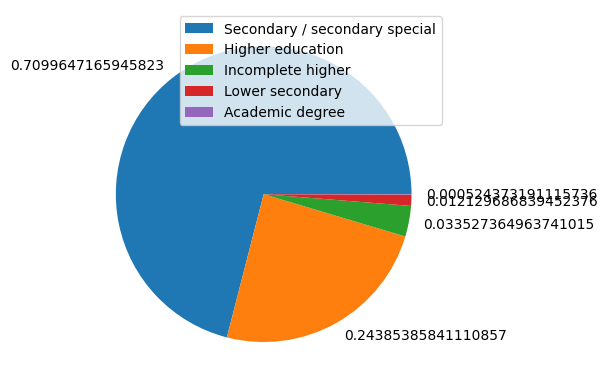

In [11]:
### TODO Complete in this cell: level of education plot
count = app_train['NAME_EDUCATION_TYPE'].value_counts().to_dict()
df = pd.DataFrame(columns=['edu', 'count', 'percent'])

for i,row in enumerate(count):
    df.loc[i,'edu'] = row
    df.loc[i,'count'] = count[row]
    df.loc[i,'percent'] = count[row]/total_rows
print(df)

plt.Figure()
plt.pie(df['percent'], labels=df['percent'])
plt.legend(df['edu'])

1.11. Plot the distribution of ocupation of the loan applicants.

*Hint:* Take a look at `OCCUPATION_TYPE` column.

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17],
 [Text(0, 0, 'Core staff'),
  Text(1, 0, 'Accountants'),
  Text(2, 0, 'Cleaning staff'),
  Text(3, 0, 'Managers'),
  Text(4, 0, 'Medicine staff'),
  Text(5, 0, 'High skill tech staff'),
  Text(6, 0, 'Drivers'),
  Text(7, 0, 'Laborers'),
  Text(8, 0, 'Security staff'),
  Text(9, 0, 'Sales staff'),
  Text(10, 0, 'Cooking staff'),
  Text(11, 0, 'Realty agents'),
  Text(12, 0, 'Secretaries'),
  Text(13, 0, 'Waiters/barmen staff'),
  Text(14, 0, 'IT staff'),
  Text(15, 0, 'Low-skill Laborers'),
  Text(16, 0, 'Private service staff'),
  Text(17, 0, 'HR staff')])

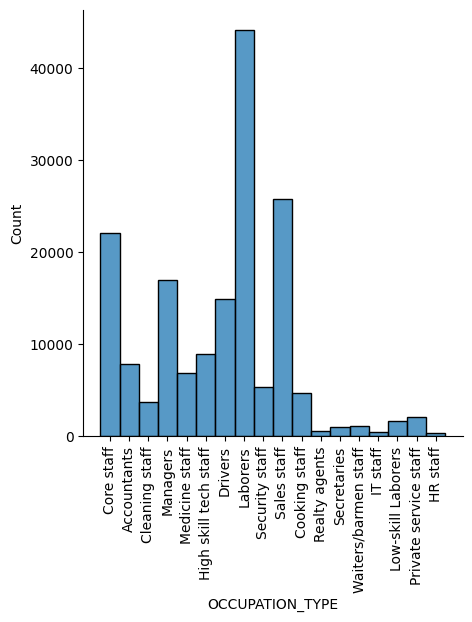

In [12]:
### TODO Complete in this cell: ocupation of applicants
plt.Figure()
sns.displot(app_train['OCCUPATION_TYPE'])
plt.xticks(rotation=90)

1.12. Plot the family status of the applicants.

*Hint:* Take a look at `NAME_FAMILY_STATUS` column.

(array([0, 1, 2, 3, 4, 5]),
 [Text(0, 0, 'Widow'),
  Text(1, 0, 'Married'),
  Text(2, 0, 'Single / not married'),
  Text(3, 0, 'Civil marriage'),
  Text(4, 0, 'Separated'),
  Text(5, 0, 'Unknown')])

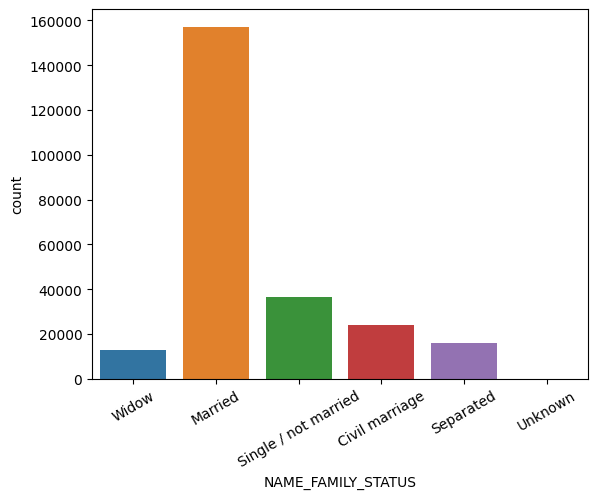

In [13]:
### TODO Complete in this cell: family status
plt.Figure()
sns.countplot(data=app_train, x = 'NAME_FAMILY_STATUS')
plt.xticks(rotation = 30)

1.13. Plot the income type of applicants grouped by the target variable.

*Hint:* Take a look at `NAME_INCOME_TYPE` and `TARGET` columns. You can use `hue` parameter on Seaborn to group samples using another categorical feature.

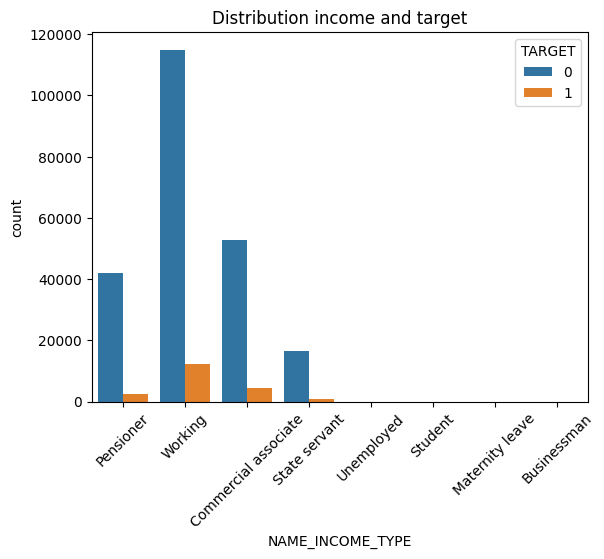

In [14]:
### TODO Complete in this cell: Income type of applicants by target variable
plt.figure()
sns.countplot(data=app_train, x='NAME_INCOME_TYPE', hue='TARGET')
plt.xticks(rotation = 45)
plt.title('Distribution income and target')
plt.show()

## 2. Preprocessing

2.1. The next step will be to separate our train and test datasets columns between Features (the input to the model) and Targets (what the model has to predict with the given features).

**Don't change anything in this cell, just make it run correctly**

In [15]:
# Now we execute the function above to get the result
X_train, y_train, X_test, y_test = data_utils.get_feature_target(app_train, app_test)

2.2. In order to avoid overfitting while searching for the best model hyperparameters, it's always a good idea to split our training dataset into two new sets called `train` and `validation`. 

**Don't change anything in this cell, just make it run correctly**

In [16]:
# Now we execute the function above to get the result
X_train, X_val, y_train, y_val = data_utils.get_train_val_sets(X_train, y_train)

## 3. Pipeline for Training and preprocess

The model for used for this problem is Lightgbm

In [17]:
#The preprocessing.py function contains the process
xtrain, xval, xtest= preprocessing.fix_anomalous_days(X_train, X_val, X_test)
pipeline, all_cols = preprocessing.build_pipeline(xtrain)

In [18]:
#Pipeline training
pipeline.fit(xtrain,y_train) 

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['SK_ID_CURR', 'CNT_CHILDREN',
                                                   'AMT_INCOME_TOTAL',
                                                   'AMT_CREDIT', 'AMT_ANNUITY',
                                                   'AMT_GOODS_PRICE',
                                                   'REGION_POPULATION_RELATIVE',
                                                   'DAYS_BIRTH',
                                                   'DAYS_EMPLOYED',
                                                   'DAYS_REGISTRATION',
                                                   'DAYS_ID_PUBLISH',...
                                                  ['CODE_GENDER',
                                                   'NAME_TYPE_SUITE',
                                                   'NAME_INCOME_TYPE',
                                                   'NAME_EDUCATION_TYPE',
                                                   'NAME_FAMILY_STATUS',
                                                   'NAME_HOUSING_TYPE',
                                                   'OCCUPATION_TYPE',
                                                   'WEEKDAY_APPR_PROCESS_START',
                                                   'ORGANIZATION_TYPE',
                                                   'FONDKAPREMONT_MODE',
                                                   'HOUSETYPE_MODE',
                                                   'WALLSMATERIAL_MODE'])])),
                ('model',
                 LGBMClassifier(metric='binary_logloss', n_jobs=-1,
                                objective='binary', task='train',
                                verbose=-1))])

In [19]:
#Predictions
predictions=pipeline.predict_proba(xval)[:,1]

In [20]:
print(f'the ROC AUC score is: {roc_auc_score(y_true=y_val, y_score=predictions)}')

the ROC AUC score is: 0.7535312787889277
